In [10]:
##Preable
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

In [11]:
def fillShape(grid,points): ##Fills a shape given a set of points, connects the points in the order given
    outline = np.zeros([len(grid),len(grid)]) ##Create a grid to hold the outline
    for i in range(len(points)): 
        ##For each pair of points, define the line connecting them
        ##Then fill in the nearest y point to the line for every x between the two points
        j = (i + 1)%len(points)
        if points[i][0] - points[j][0] != 0:
            if points[i][0] < points[j][0]:
                x1 = points[i][0]
                y1 = points[i][1]
                x2 = points[j][0]
                y2 = points[j][1]
            else:
                x1 = points[j][0]
                y1 = points[j][1]
                x2 = points[i][0]
                y2 = points[i][1]
            for k in range(x1,x2):
                y = int(((y1-y2)/(x1-x2))*(k - x1) + y1)
                outline[k][y] = 1
        else: ##If the points are not horizontally separated, do above but flip x and y
            if points[i][1] < points[j][1]:
                x1 = points[i][0]
                y1 = points[i][1]
                x2 = points[j][0]
                y2 = points[j][1]
            else:
                x1 = points[j][0]
                y1 = points[j][1]
                x2 = points[i][0]
                y2 = points[i][1]
            for k in range(y1,y2):
                x = int(((x1-x2)/(y1-y2))*(k - y1) + x1)
                outline[x][k] = 1
             
    for i in range(len(grid)): ##For each point on the grid, draw a line to the left edge. 
        ##If this line passes the outline once, the point is in the outline and gets filled in
        ##If the line passes the outline nonce or twice, the point is outside the outline and is left blank
        ##If the entire row only has one outline point, the entire row is set to white
        totalPasses = 0
        for j in range(len(grid)):
            passes = 0
            if outline[i][j] == 1:
                totalPasses += 1
            for k in range(j):
                if outline[i][j-k] == 1:
                    passes += 1
            if passes == 1:
                grid[i][j] = 1
        if totalPasses == 1 or totalPasses > 2:
            grid[i] = 0
    
    return grid

In [12]:
def getTimes(filename): ##Gets the time array from the TESS Light Curve
    fp = open("./TESSCurves/"+filename+".pkl","rb") ##Loading the file
    data = pickle.load(fp)
    fp.close()

    q = data[11]==0 #Extracting the data we want, can only keep high quality data
    times = data[6][q]
    midTime = np.percentile(times,33) ##Set the 0 point at 1/3. Eight Bit Transit centers light curves at 0 so put this where you want to center the transit
    ##Tess light curves seem to have a 2 day gap near the center
    times = times - midTime
    return times

In [63]:
def generatePoints(n,r,size,xoffset = 0,yoffset = 0,rotation = 0, proportion = 1, rot = 0): ##Generates points of a regular polygon with n edges, radius of r*size
    ##Size is grid size, 0 < r < 0.5, rotation rotates the shape from having a point vertically down
    points = []
    ystretch = np.sqrt(proportion)
    xstretch = 1/np.sqrt(proportion)
    for i in range(n):
        y = ystretch*r*size*np.cos(i*2*np.pi/n + rot)
        x = xstretch*r*size*np.sin(i*2*np.pi/n + rot)
        nuy = int(x*np.sin(rotation)+y*np.cos(rotation) + yoffset)
        nux = int(x*np.cos(rotation)-y*np.sin(rotation) + xoffset)
        points.append([nux,nuy])
    return points

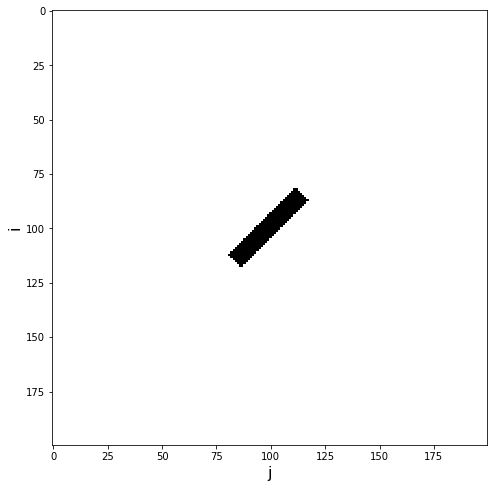

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


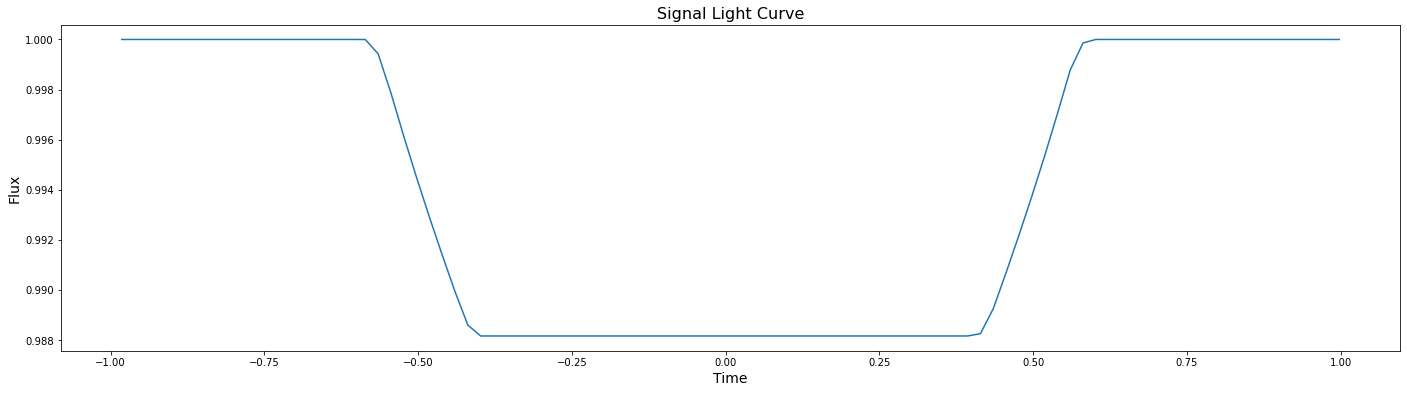

'\nfor i in range(11): \n    for j in range(12):\n        points = generatePoints(i+3,0.07,200,100,100,j*np.pi/12)\n        planetGrid = fillShape(np.zeros([200,200]),points)\n        planet = TransitingImage(opacitymat = planetGrid, v = 2, t_ref = 0, t_arr = times)\n        planetLC, overlapTimes = planet.gen_LC(t_arr = times)\n \n        f = open("Signals/n"+str(i+3)+"t"+str(j*360/12)+".txt",\'w\')\n        for k in range(len(overlapTimes)):\n            f.write(str(overlapTimes[k]) + \'\t\' + str(planetLC[k]) + \'\n\')\n        f.close()\n'

In [65]:
times = getTimes("tesslc_364539361")

points = generatePoints(4,0.07,200,100,100,np.pi/4,5, np.pi/4)
planetGrid = fillShape(np.zeros([200,200]),points)
planet = TransitingImage(opacitymat = planetGrid, v = 2, t_ref = 0, t_arr = times)
planet.plot_grid()
planetLC, overlapTimes = planet.gen_LC(t_arr = times)

fig, ax = plt.subplots(1,1,figsize=(24,6))##Plotting for good measure
ax.plot(overlapTimes,planetLC)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Flux",fontsize=14)
plt.title(r"Signal Light Curve",fontsize=16)
plt.show()


'''
for i in range(11): 
    for j in range(12):
        points = generatePoints(i+3,0.07,200,100,100,j*np.pi/12)
        planetGrid = fillShape(np.zeros([200,200]),points)
        planet = TransitingImage(opacitymat = planetGrid, v = 2, t_ref = 0, t_arr = times)
        planetLC, overlapTimes = planet.gen_LC(t_arr = times)
 
        f = open("Signals/n"+str(i+3)+"t"+str(j*360/12)+".txt",'w')
        for k in range(len(overlapTimes)):
            f.write(str(overlapTimes[k]) + '\t' + str(planetLC[k]) + '\n')
        f.close()
'''
    